(content:melcepstrum)=
# The cepstrum, mel-cepstrum and mel-frequency cepstral coefficients (MFCCs)

The spectrogram is a useful representation of speech in the sense that it visualizes effectively many pertinent features of speech signals. In particular, we can observe events over time, changes in fundamental frequency and also some features of the spectral envelope. It however also comes with its drawbacks. It is not a particularly efficient representation in terms of number of coefficients; the spectrum has a large number of coefficients in comparison to the amout of information which we are after. Typically we would like to have information of the formant locations and amplitudes, which could be represented by just a handful of coefficients. Similarly, the fundamental frequency is just one piece of information, but it is hidden in a multitude of frequency components.

## The cepstrum

Many central properties of speech signals are clearly visible as structures in the log-spectrum, for example, the envelope is the smooth macro-structure and the fundamental frequency $F_0$ is a harmonic comb-structure. Both types of structures can be easily analyzed with a time-frequency transform. Specifically, since the structures are visible in the log-spectrum, we should take the discrete Fourier transform or discrete cosine transform of the log-spectrum. We are thus applying two time-frequency transform to the original time signal, but with the non-linear operation, logarithm of the absolute value, in between.  

The algorithm is 
1. Apply analysis windowing to signal
2. Apply time-frequency transform (DFT or DCT)
3. Take the logarithm of the absolute value
4. Apply second time-frequency transform

The output after the second time-frequency transform is known as the *cepstrum*, because it is backwards transform of the *spectrum*. The word-play was chosen such that it would be funny. Similarly, the x-axis in the cepstrum is known as the *quefrency*, as corresponding to *frequency*. Since the cepstrum is a result of two consecutive time-frequncy transforms, the unit in the quefrency will be *seconds*.

In [1]:
# Initialization
import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import scipy.fft
import numpy as np

import helper_functions # local file helper_functions.py

filename = 'sounds/cepstrum_test.wav'
np.random.seed(297)


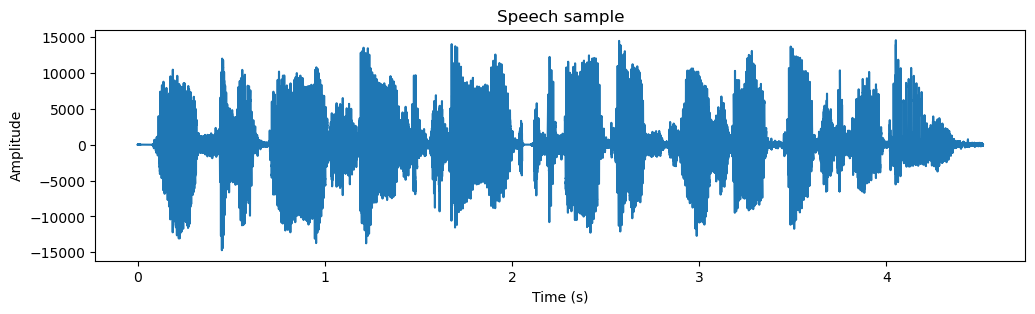

In [2]:
# read from storage
fs, data = wavfile.read(filename)
data = data[:,0]

window_length_ms = 40
window_step_ms = 20
spectrum_length = 5000
window_length = int(window_length_ms*fs/1000)
window_step = int(window_step_ms*fs/1000)
windowing_function = np.sin(np.pi*np.arange(0.5,window_length,1)/window_length)**2
total_length = len(data)

t = np.arange(0,total_length)/fs
plt.figure(figsize=[12,3])
plt.plot(t,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Speech sample')
plt.show()

<>:62: SyntaxWarning: invalid escape sequence '\l'
<>:62: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipykernel_129390/628358410.py:62: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('Log-Magnitude $\log|C_k|$')


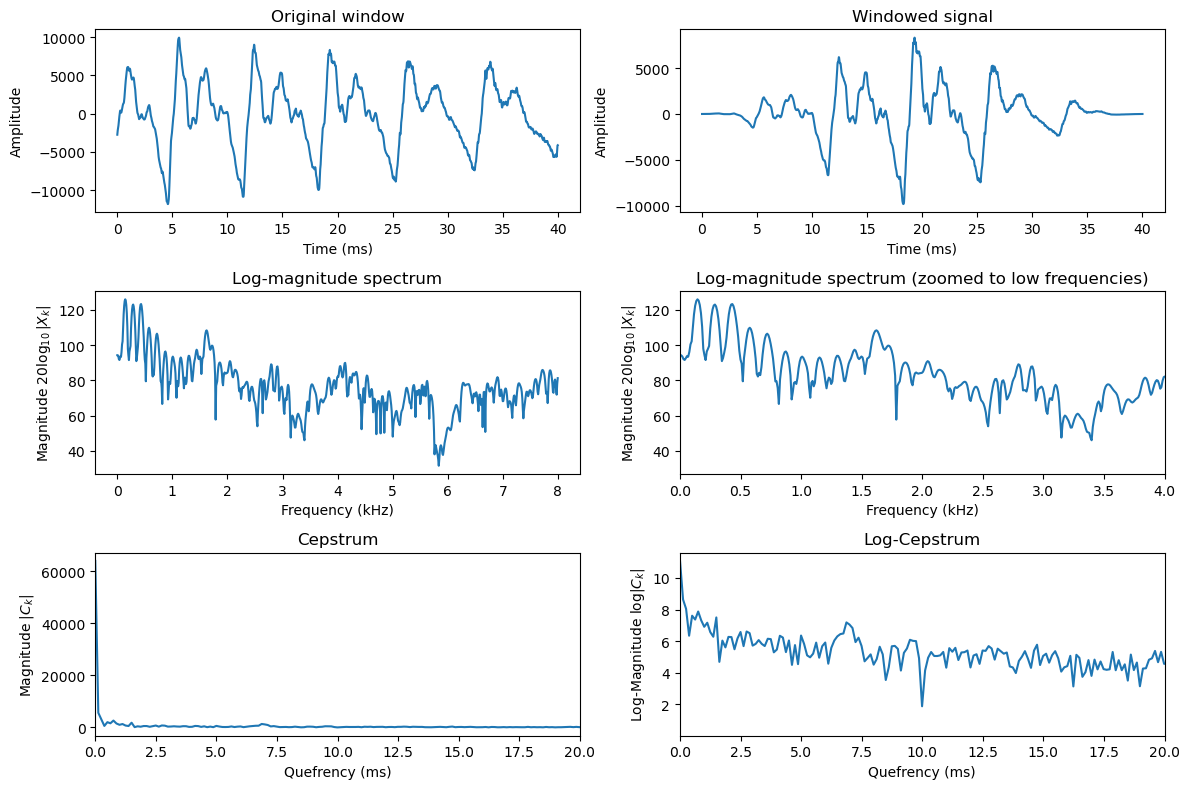

In [3]:
# choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = data[starting_position:(starting_position+window_length),]
window = data_vector*windowing_function
time_vector = np.linspace(0,window_length_ms,window_length)

spectrum = scipy.fft.rfft(window,n=spectrum_length)
frequency_vector = np.linspace(0,fs/2000,len(spectrum))

# downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]

logspectrum = 20*np.log10(np.abs(spectrum))
cepstrum = scipy.fft.rfft(logspectrum)

ctime = np.linspace(0,0.5*1000*spectrum_length/fs,len(cepstrum))

plt.figure(figsize=[12,8])
plt.subplot(321)
plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(322)
plt.plot(time_vector,window)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')

plt.subplot(323)
plt.plot(frequency_vector,logspectrum)
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$')

plt.subplot(324)
plt.plot(frequency_vector,logspectrum)
plt.title('Log-magnitude spectrum (zoomed to low frequencies)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
ax = plt.axis()
ax = [0, 4, ax[2], ax[3]]
plt.axis(ax)

plt.subplot(325)
plt.plot(ctime,np.abs(cepstrum))
plt.title('Cepstrum')
plt.xlabel('Quefrency (ms)')
plt.ylabel('Magnitude $|C_k|$')
ax = plt.axis()
ax = [0, 20, ax[2], ax[3]]
plt.axis(ax)

plt.subplot(326)
plt.plot(ctime,np.log(np.abs(cepstrum)))
plt.title('Log-Cepstrum')
plt.xlabel('Quefrency (ms)')
plt.ylabel('Log-Magnitude $\\log|C_k|$')
ax = plt.axis()
ax = [0, 20, ax[2], ax[3]]
plt.axis(ax)
plt.tight_layout()
plt.show()


## Features in the Cepstrum

The envelope of the spectrum is a smoothed version, so it should be present in the low part of the cepstrum. The interpretation of the lowest coefficients is however not intuitive. Moreover, observe that the power spectrum can sometimes be zero or very close to zero, such that the log-spectrum approaches negative infinity. Isolated zeros should not have any effect on the envelope, but in the log-domain, very large negative values have a large contribution to the cepstrum. The cepstrum, as such, is therefore not very well suited for envelope modelling.

However, the F0 is usually prominently visible as a peak in the cepstrum. Since this domain is similar to the time-domain, the cepstral peak will be visible at the same quefrency value as the period-length of the original time signal.

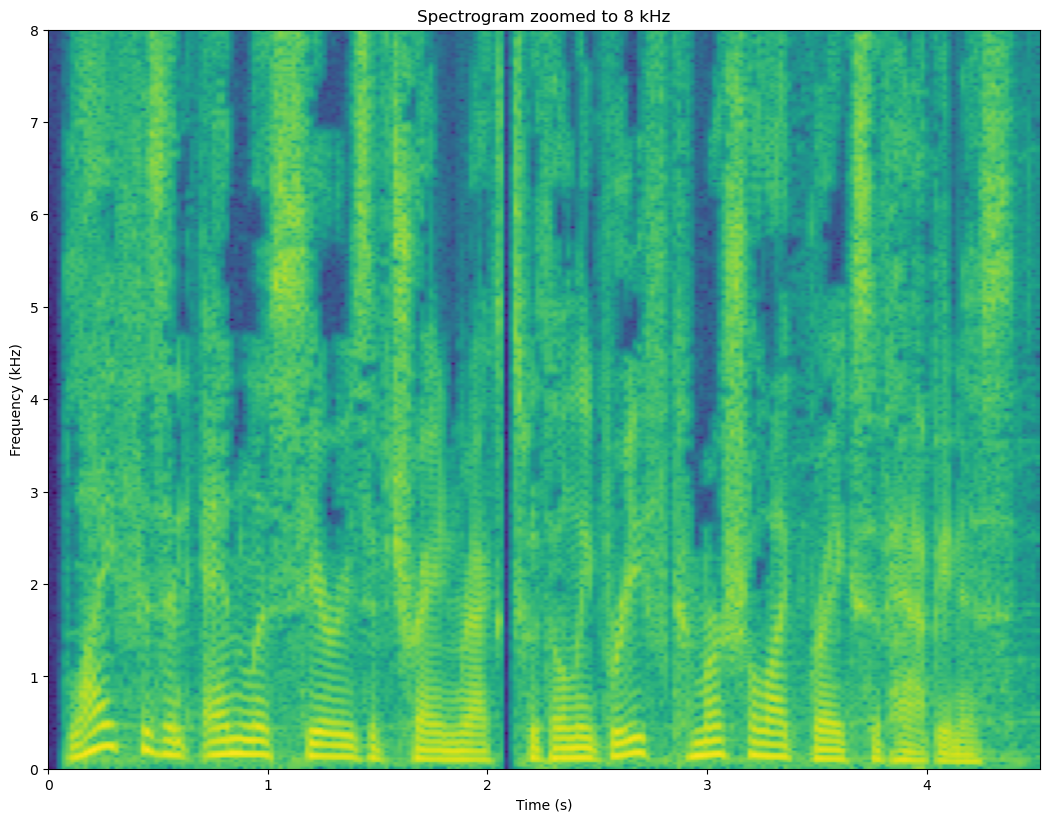

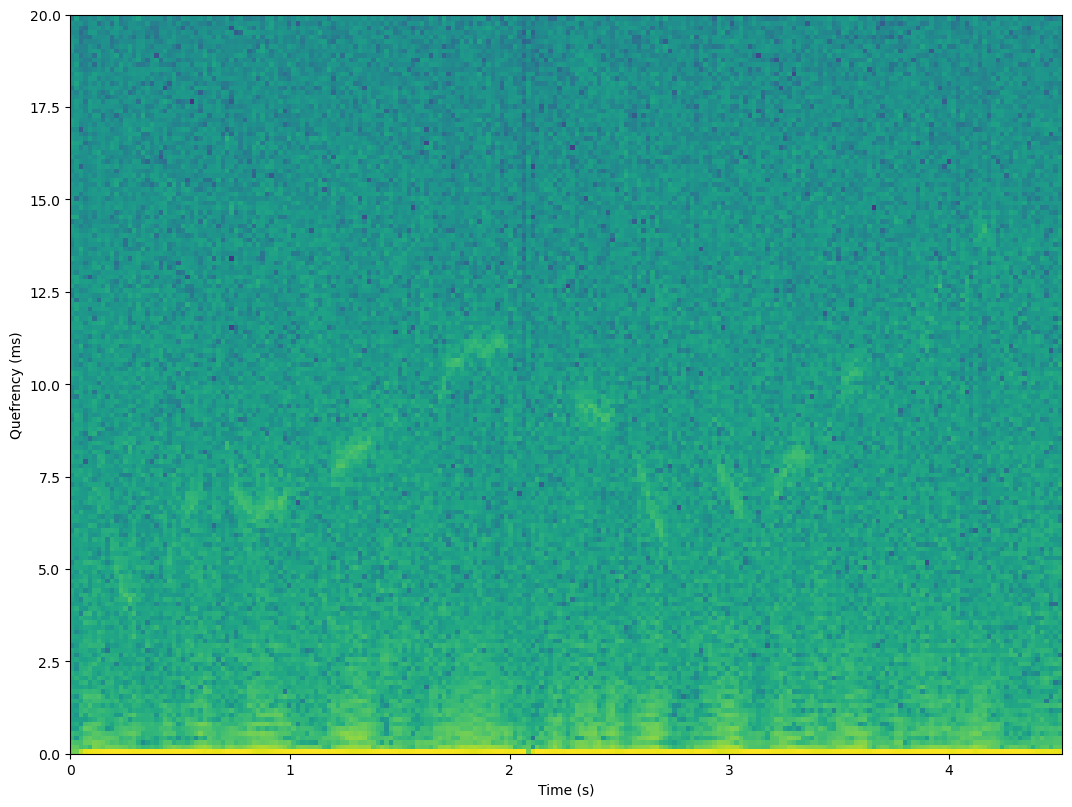

In [4]:
spectrogram = helper_functions.stft(data,fs,window_length_ms=window_length_ms,window_step_ms=window_step_ms)
window_count = spectrogram.shape[0]

cepstrogram = np.zeros((len(cepstrum),window_count))

for k in range(window_count): 
    starting_position = k*window_step
    data_vector = data[starting_position:(starting_position+window_length),]
    window = data_vector*windowing_function
    time_vector = np.linspace(0,window_length_ms,window_length)

    spectrum = scipy.fft.rfft(window,n=spectrum_length)
    frequency_vector = np.linspace(0,fs/2000,len(spectrum))

    # downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
    idx = np.nonzero(frequency_vector <= 8)
    frequency_vector = frequency_vector[idx]
    spectrum = spectrum[idx]

    logspectrum = 20*np.log10(np.abs(spectrum))
    cepstrum = scipy.fft.rfft(logspectrum)
    cepstrogram[:,k] = np.abs(cepstrum)
    
#    cepstrogram[:,k] = np.abs(scipy.fft.rfft(20*np.log10(np.abs(spectrogram[k,idx])),axis=1))
#cepstrogram = np.abs(scipy.fft.rfft(20*np.log10(np.abs(spectrogram[:,idx])),axis=1))


black_eps = 1e-1 # minimum value for the log-value in the spectrogram - helps making the background really black
    
import matplotlib as mpl
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]

mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.axis([0, len(data)/fs, 0, 8])
plt.title('Spectrogram zoomed to 8 kHz')
plt.show()


plt.imshow(np.log(np.abs(cepstrogram)+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, ctime[-1]])
#plt.imshow(np.log(np.abs(cepstrogram)+black_eps),aspect='auto',origin='lower')
plt.xlabel('Time (s)')
plt.ylabel('Quefrency (ms)')
plt.axis([0, len(data)/fs, 0, 20])
#plt.title('Spectrogram zoomed to 8 kHz')
plt.show()



We can clearly see the a curve between quefrency 5 and 12 ms undulating up and down over time. 
The quefrencies $q$ can be easily converted to frequencies $f$ by $f=1/q$ (but remember to first convert milliseconds to seconds).

## Down-sampling the log-spectrum

The cepstrum is good for extracting envelope and F0-information, but it is not particularly efficient in the sense that it has a large number of coefficients for a little amount of information. The envelope information is about the slowly-varying shape of the log-spectrum, so we could try to extract that by a simple downsampling. However, a problem is that the power-spectrum can sometimes have arbitrarily small values, which in the log-spectrum translate to negative near-infinite values. Any information extraction in the log-domain would therefore be susceptible for bias to negative infinite.

A solution is to apply smoothing in the power-spectrum. For example, we could use a FIR-filter $[0.5,1,0.5]$, or more generally, a triangular shape. In heuristic terms, we just take an average of the power around a certain frequency, such that frequencies near have a larger weight than frequencies far away. The weighting parameters are then chosen in a triangular shape. We calculate the smoothed samples at intervals corresponding to half the width of the triangle, such that the amount of samples obtained corresponds to the amount of smoothing. More rigorously, we can first apply the FIR-filter and then apply down-sampling by an appropriate amount, but the end-result is the same.

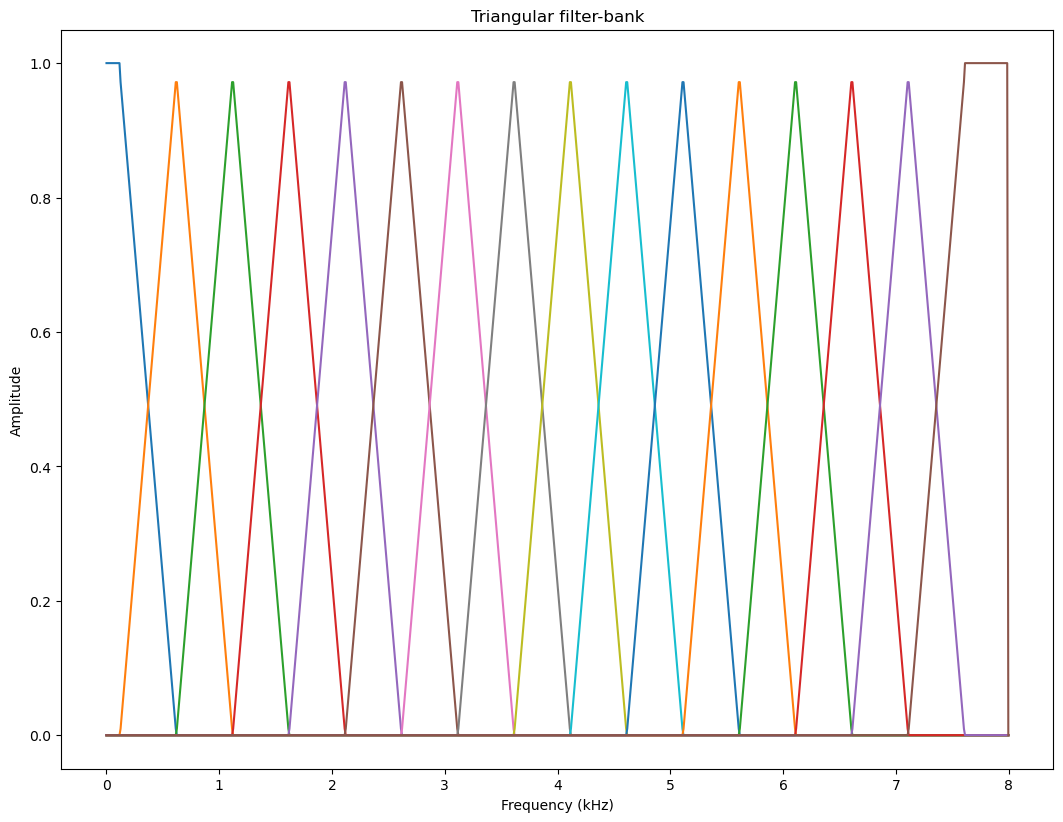

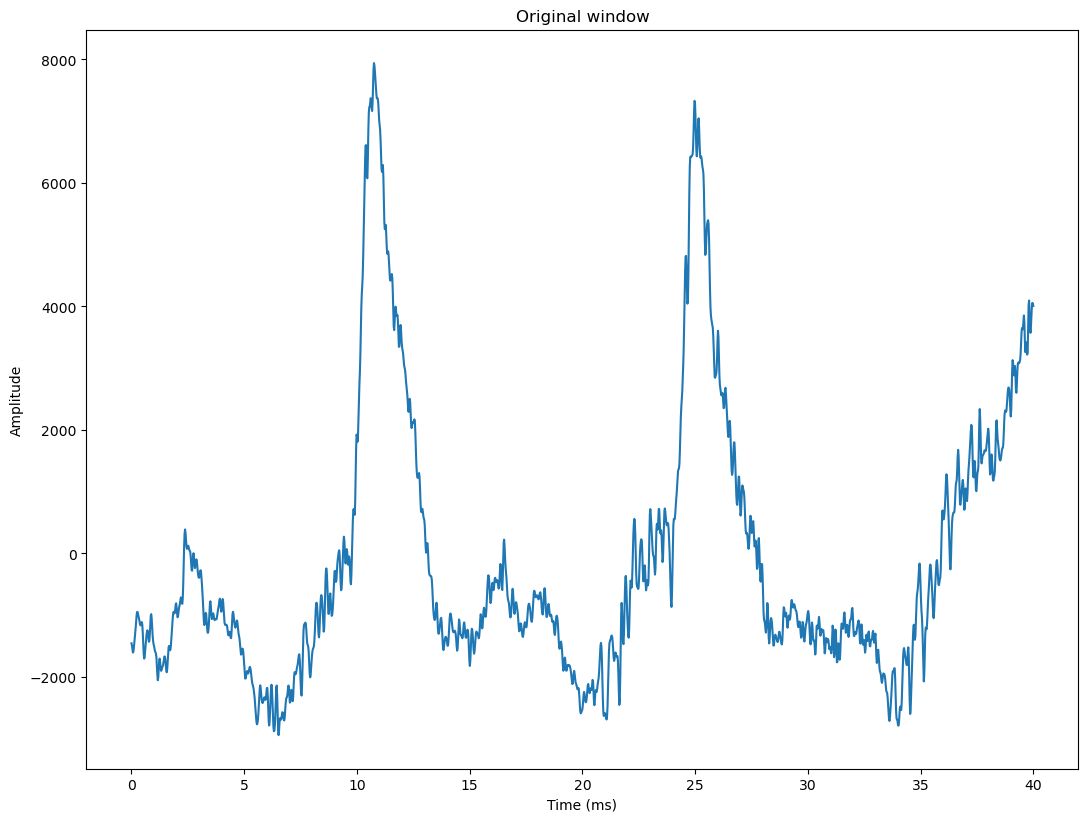

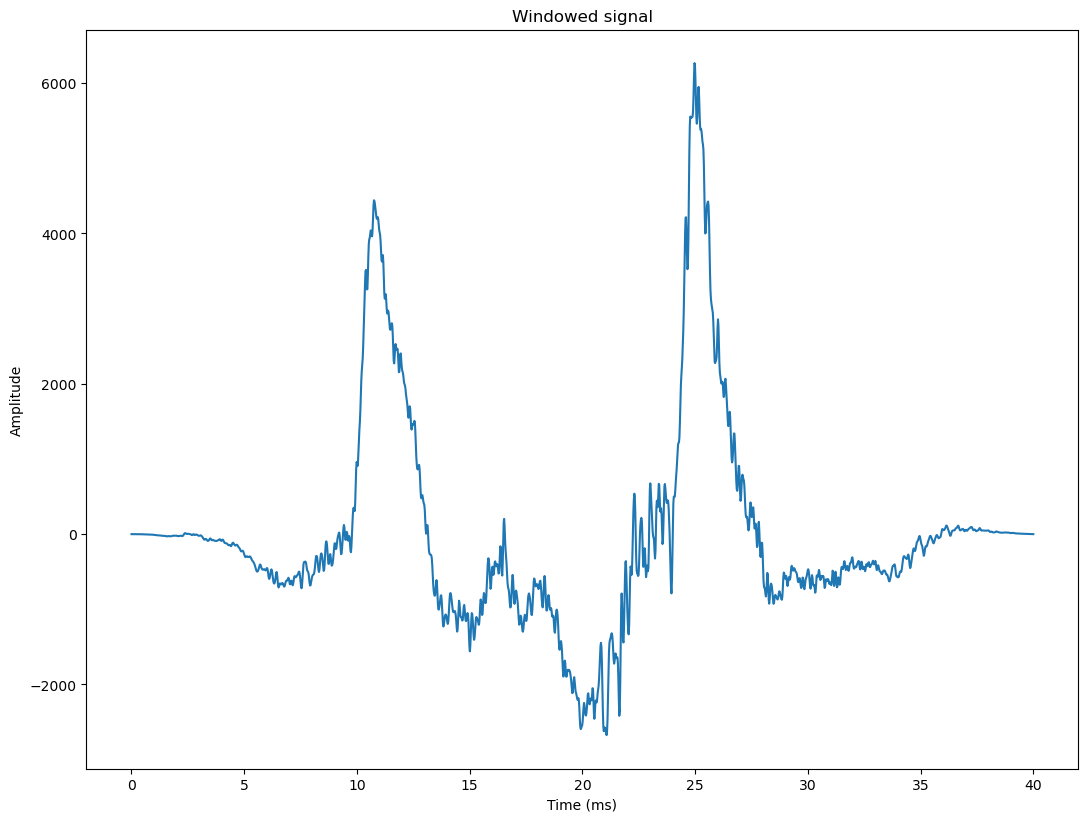

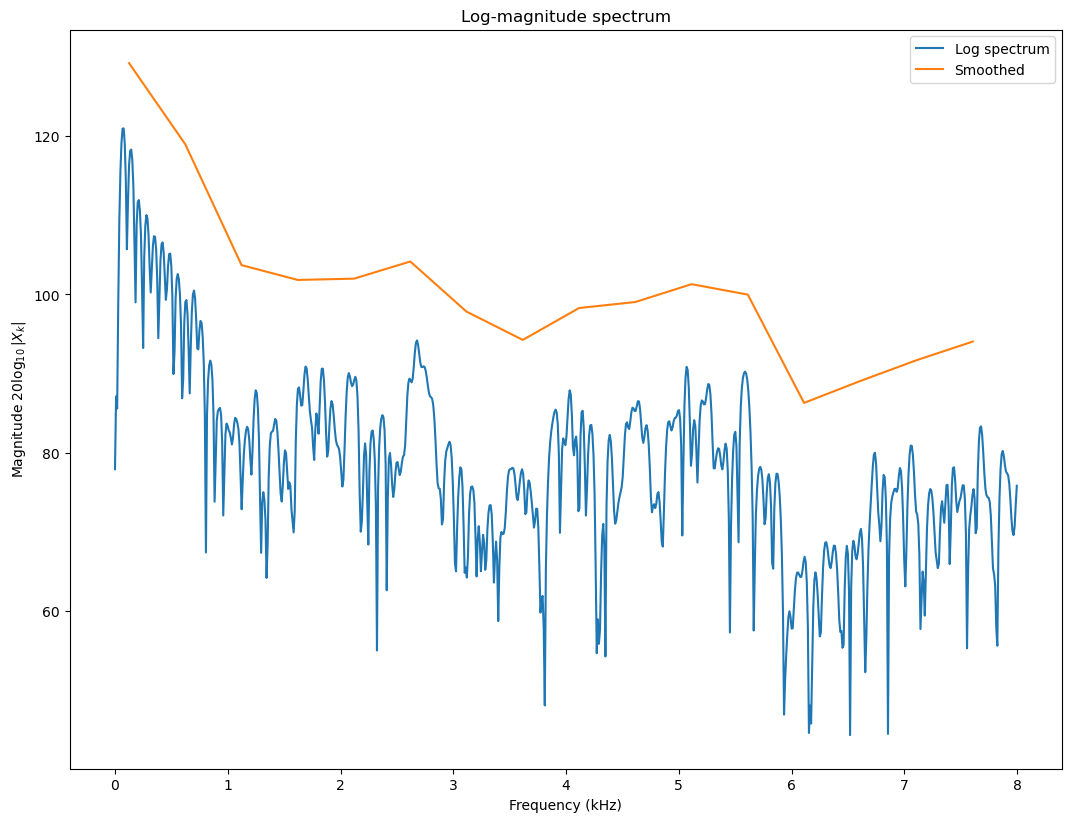

In [5]:


# choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = data[starting_position:(starting_position+window_length),]
window = data_vector*windowing_function
time_vector = np.linspace(0,window_length_ms,window_length)

spectrum = scipy.fft.rfft(window,n=spectrum_length)
frequency_vector = np.linspace(0,fs/2000,len(spectrum))

# downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]

logspectrum = 20*np.log10(np.abs(spectrum))


# filterbank
frequency_step_Hz = 500
frequency_step = int(len(spectrum)*frequency_step_Hz/8000)
frequency_bins = int(len(spectrum)/frequency_step+.5)

slope = np.arange(.5,frequency_step+.5,1)/(frequency_step+1)
backslope = np.flipud(slope)
filterbank = np.zeros((len(spectrum),frequency_bins))
filterbank[0:frequency_step,0] = 1
filterbank[(-frequency_step):-1,-1] = 1
for k in range(frequency_bins-1):
    idx = int((k+0.25)*frequency_step) + np.arange(0,frequency_step)
    filterbank[idx,k+1] = slope
    filterbank[idx,k] = backslope
    
# smoothing and downsampling
spectrum_smoothed = np.matmul(np.transpose(filterbank),np.abs(spectrum)**2)
logspectrum_smoothed = 10*np.log10(spectrum_smoothed)
frequency_vector_tight = (np.arange(0,frequency_bins,1)+0.25)*frequency_step*8/len(spectrum)

plt.plot(frequency_vector,filterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('Triangular filter-bank')
plt.show()

plt.plot(time_vector,data_vector)
plt.title('Original window')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

plt.plot(time_vector,window)
plt.title('Windowed signal')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude')
plt.show()

plt.plot(frequency_vector,logspectrum,label='Log spectrum')
plt.plot(frequency_vector_tight,logspectrum_smoothed,label='Smoothed')
plt.legend()
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\\log_{10}|X_k|$')
plt.show()




The smoothed representation clearly catches the overall shape of the spectrum, which is the envelope. It achieves this with a low number of coefficient, which means that it is a reasonably efficient model of the envelope. However, a downside is that the information does not reflect the importance of features for humans. Taking the log-transform does map magnitudes to a perceptual scale, but the frequency scale is still not mapped to a perceptual domain. 

(content:melscale)=
## Mel-scale

The [mel-scale](https://en.wikipedia.org/wiki/Mel_scale) is a scale which maps frequencies such that steps between tones align with our perception of steps. That is, for example, the step from X to X+1 mel sounds as large as the step from Y to Y+1 mel. More details in the above link.
We then form a filterbank such that the triangle-centres are at the frequencies corresponding to equal distance steps on the mel scale.

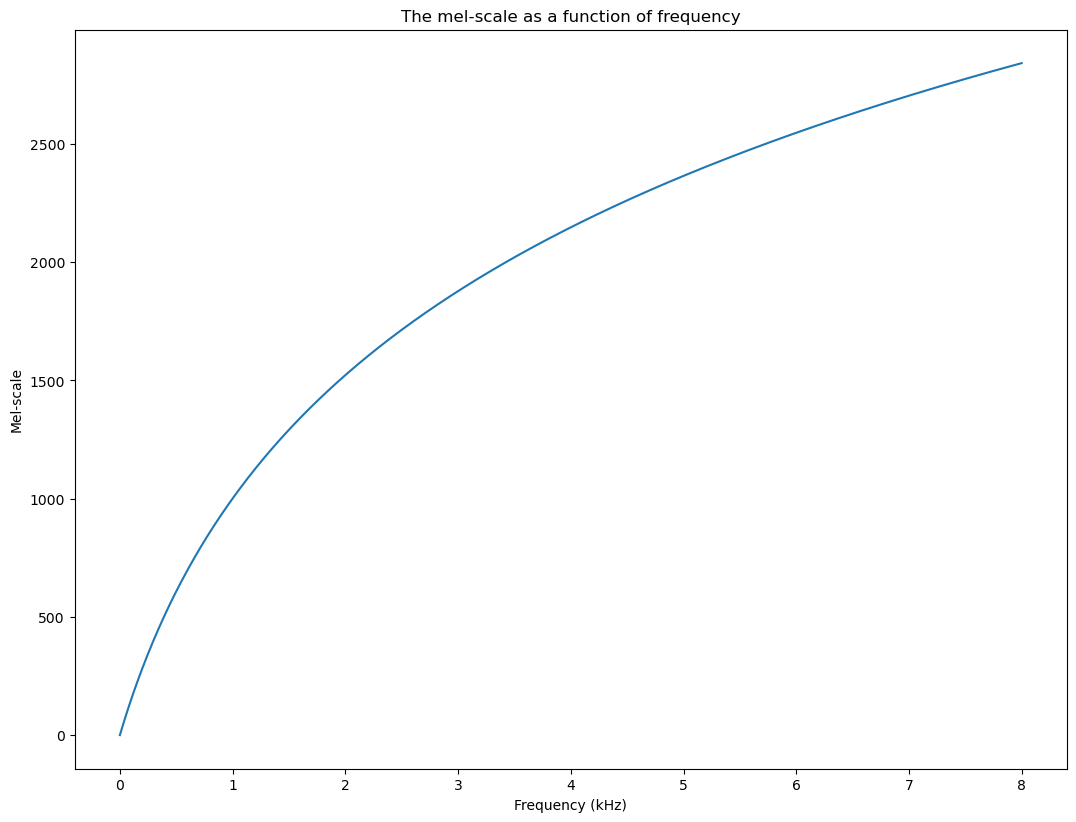

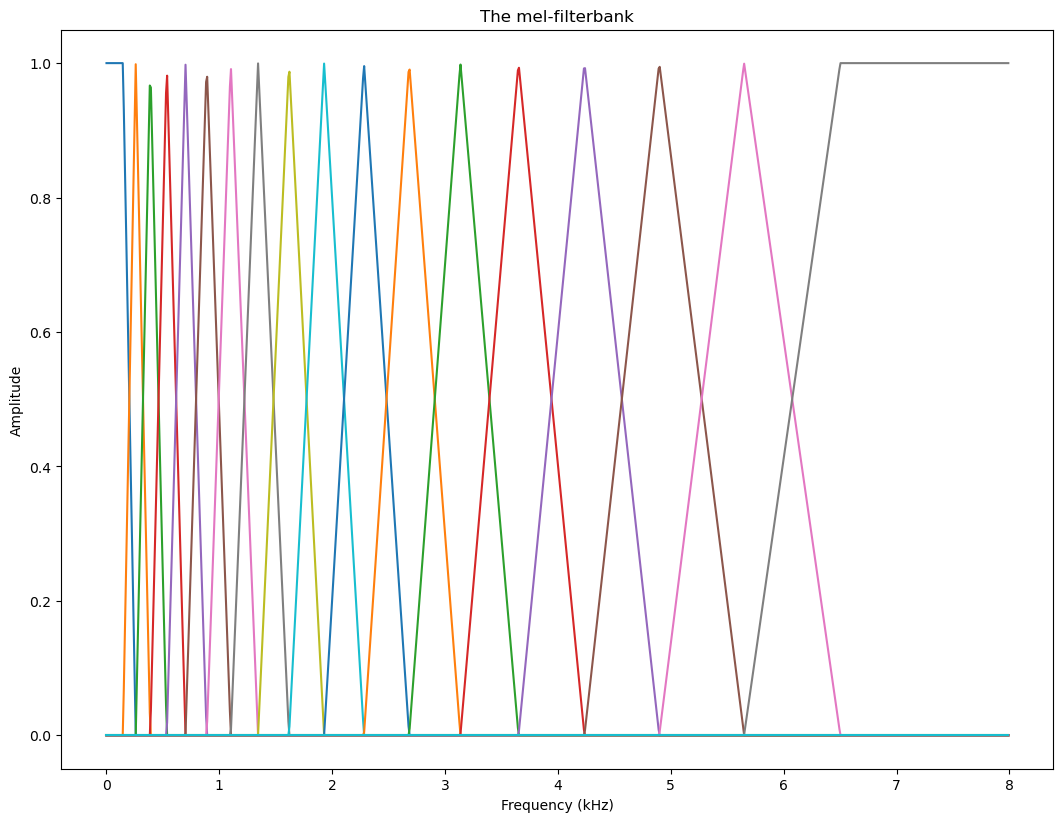

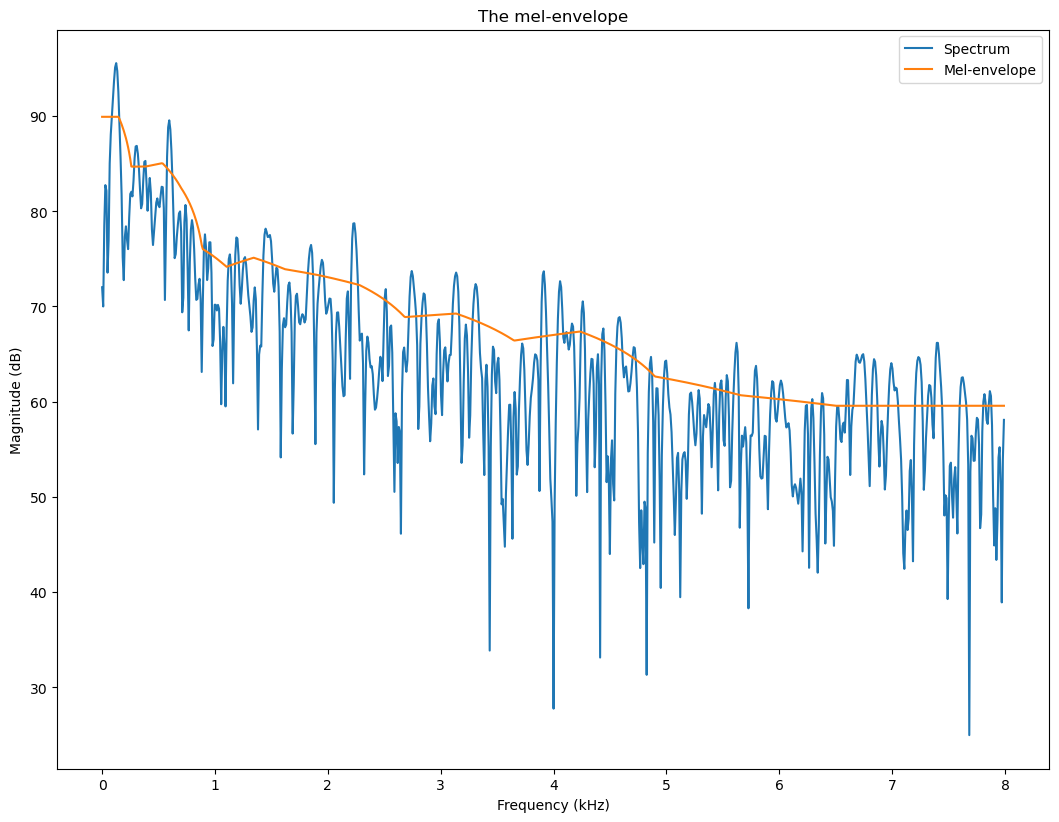

In [6]:
def freq2mel(f): return 2595*np.log10(1 + (f/700))
def mel2freq(m): return 700*(10**(m/2595) - 1)

f = np.linspace(0,8000,1000)
plt.plot(f/1000,freq2mel(f))
plt.xlabel('Frequency (kHz)')
plt.ylabel('Mel-scale')
plt.title('The mel-scale as a function of frequency')
plt.show()

melbands = 20
maxmel = freq2mel(8000)
mel_idx = np.array(np.arange(.5,melbands,1)/melbands)*maxmel
freq_idx = mel2freq(mel_idx)

melfilterbank = np.zeros((len(spectrum),melbands))
freqvec = np.arange(0,len(spectrum),1)*8000/len(spectrum)
for k in range(melbands-2):    
    if k>0:
        upslope = (freqvec-freq_idx[k])/(freq_idx[k+1]-freq_idx[k])
    else:
        upslope = 1 + 0*freqvec
    if k<melbands-3:
        downslope = 1 - (freqvec-freq_idx[k+1])/(freq_idx[k+2]-freq_idx[k+1])
    else:
        downslope = 1 + 0*freqvec
    triangle = np.max([0*freqvec,np.min([upslope,downslope],axis=0)],axis=0)
    melfilterbank[:,k] = triangle
    
melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))
    
plt.plot(freqvec/1000,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()
                           
#plt.plot(freqvec/1000,np.transpose(melreconstruct))
#plt.xlabel('Frequency (kHz)')
#plt.ylabel('Amplitude')
#plt.title('The mel-filterbank')
#plt.show()




# choose segment from random position in sample
starting_position = np.random.randint(total_length - window_length)

data_vector = data[starting_position:(starting_position+window_length),]
window = data_vector*windowing_function
time_vector = np.linspace(0,window_length_ms,window_length)

spectrum = scipy.fft.rfft(window,n=spectrum_length)
frequency_vector = np.linspace(0,fs/2000,len(spectrum))

# downsample to 16kHz (that is, Nyquist frequency is 8kHz, that is, everything about 8kHz can be removed)
idx = np.nonzero(frequency_vector <= 8)
frequency_vector = frequency_vector[idx]
spectrum = spectrum[idx]
logspectrum = 20*np.log10(np.abs(spectrum))

logmelspectrum = 10*np.log10(np.matmul(np.transpose(melfilterbank),np.abs(spectrum)**2)+1e-12)
logenvelopespectrum = 10*np.log10(np.matmul(np.transpose(melreconstruct),10**(logmelspectrum/10)))

plt.plot(freqvec/1000,logspectrum,label='Spectrum')
plt.plot(freqvec/1000,logenvelopespectrum,label='Mel-envelope')
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('The mel-envelope')
plt.show()


The mel-envelope clearly models lower frequencies accurately, which is also where the all-important formants reside. That is, accuracy is concentrated on the important part, which is good. Higher frequencies, above 6.5 kHz in particular, are poorly modelled, but there is usually not too much energy anyway, so that is ok.

A remaining issue with the log-melspectrum is however that neighbouring samples are highly correlated. That is, information is distributed throughout the individual samples. Yet we cannot reduce accuracy more, because then we would start loosing accuracy of the formants. 

(content:mfcc)=
### The Mel-Frequency Cepstral Coefficients (MFCCs)

A generic operation for decorrelating sequentially correlated data is the [discrete cosine transform (DCT)](https://en.wikipedia.org/wiki/Discrete_cosine_transform). That is, say we have a time-signal which has correlation over time, by taking the DCT, we obtain the spectrum of the signal, where samples are reasonably uncorrelated (at least when the input vector is a stationary state system and long). 

Similarly, we can thus take the DCT of the log-mel spectrum, which is known as the Mel-Frequency Cepstral coefficient (MFCC) representation. It has the mel-frequency mapping, then takes the logarithm and finally the DCT. 

The MFCC is an abstract domain, which is not easy to interpret visually. However, since it is designed to correspond to resemble perception in both magnitude and frequency axis, and to be roughly uncorrelated, it is efficient for computation. Observe that this is a perceptual argument, such that the computer simulates how humans perform. Observe that simulating the human is not always appropriate, computers can sometimes do better than humans, but often it focuses attention to the relevant sources of information.

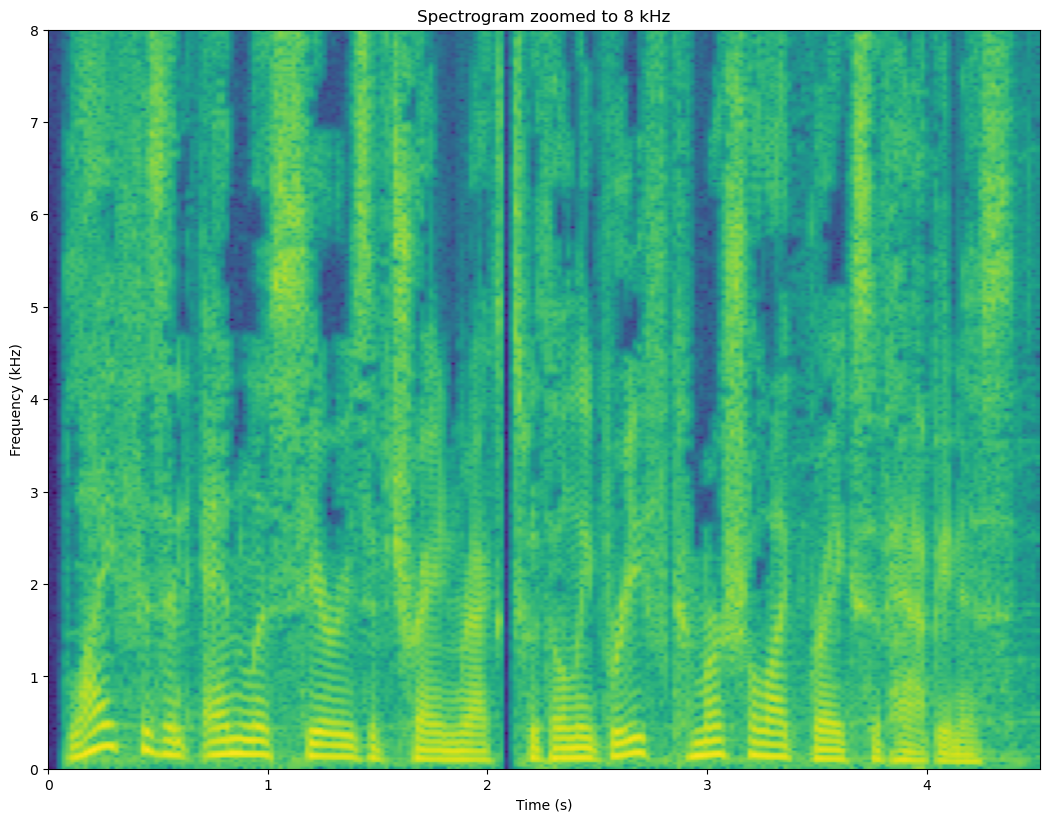

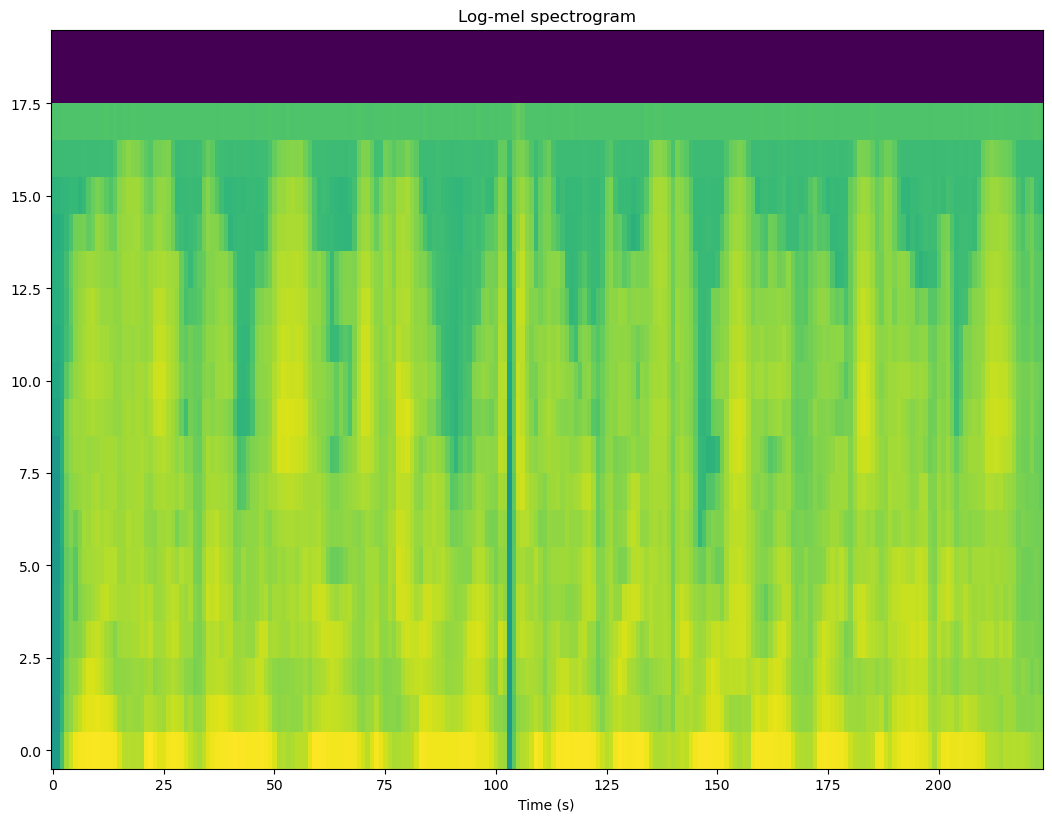

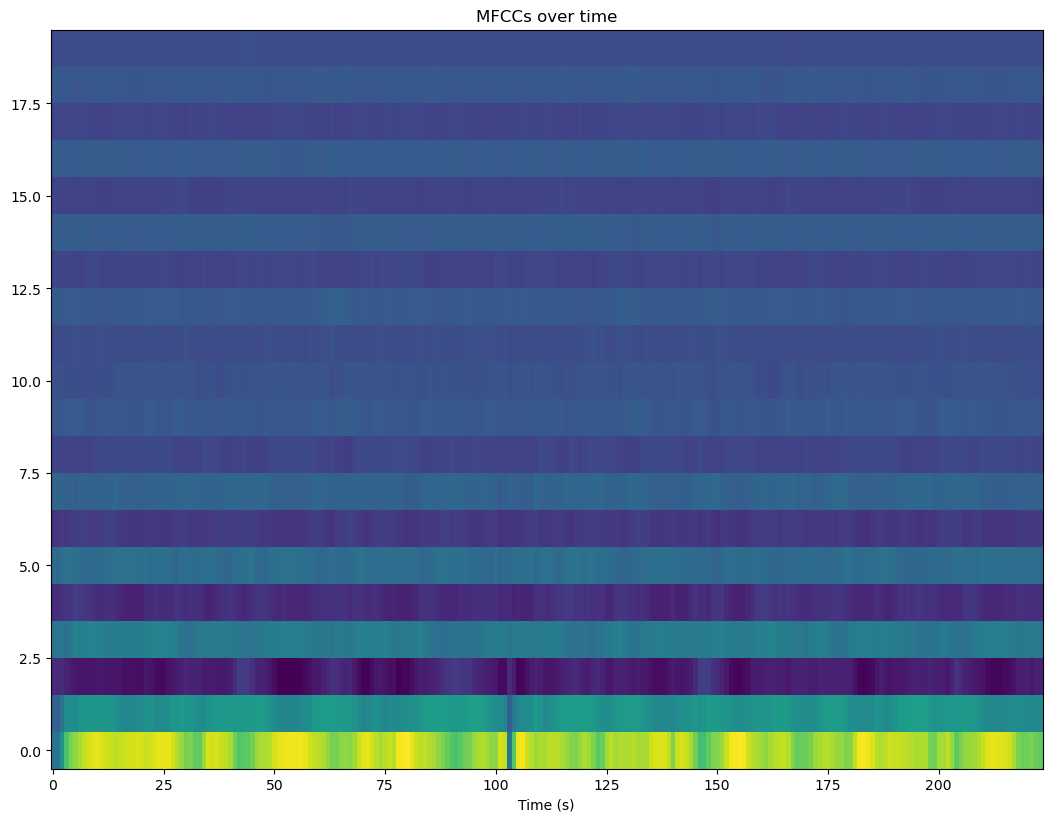

In [7]:
melbands = 20
maxmel = freq2mel(8000)
mel_idx = np.array(np.arange(.5,melbands,1)/melbands)*maxmel
freq_idx = mel2freq(mel_idx)

melfilterbank = np.zeros((spectrogram.shape[1],melbands))
freqvec = np.arange(0,spectrogram.shape[1],1)*8000/spectrogram.shape[1]
for k in range(melbands-2):    
    if k>0:
        upslope = (freqvec-freq_idx[k])/(freq_idx[k+1]-freq_idx[k])
    else:
        upslope = 1 + 0*freqvec
    if k<melbands-3:
        downslope = 1 - (freqvec-freq_idx[k+1])/(freq_idx[k+2]-freq_idx[k+1])
    else:
        downslope = 1 + 0*freqvec
    triangle = np.max([0*freqvec,np.min([upslope,downslope],axis=0)],axis=0)
    melfilterbank[:,k] = triangle
    
melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))


logmelspectrogram = 10*np.log10(np.matmul(np.abs(spectrogram)**2,melfilterbank)+1e-12)

mfcc = scipy.fft.dct(logmelspectrogram)

import matplotlib as mpl
default_figsize = mpl.rcParamsDefault['figure.figsize']
mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]

mpl.rcParams['figure.figsize'] = [val*2 for val in default_figsize]
plt.imshow(20*np.log10(np.abs(np.transpose(spectrogram))+black_eps),aspect='auto',origin='lower',extent=[0, len(data)/fs,0, fs/2000])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (kHz)')
plt.axis([0, len(data)/fs, 0, 8])
plt.title('Spectrogram zoomed to 8 kHz')
plt.show()


plt.imshow(np.transpose(logmelspectrogram),aspect='auto',origin='lower')
plt.xlabel('Time (s)')
#plt.ylabel('Quefrency (ms)')
#plt.axis([0, len(data)/fs, 0, 20])
plt.title('Log-mel spectrogram')
plt.show()


plt.imshow(np.transpose(mfcc),aspect='auto',origin='lower')
plt.xlabel('Time (s)')
#plt.ylabel('Quefrency (ms)')
#plt.axis([0, len(data)/fs, 0, 20])
plt.title('MFCCs over time')
plt.show()



The envelope is clearly visible in the log-mel spectrogram as expected. The MFCCs behave also as expected - not much is visible. Would need to normalize it over time to boost subtle changes to become visible. Such normalization (pre-whitening) is in fact a standard step for all variables which are used as input to machine learning.

## Conclusion

We have discussed the cepstrum and how it can be used to extract F0 information from a speech signal. We also showed how to extract envelope information, in particular with frequencies mapped to the mel-scale to correspond with perception of pitch. Finally, we showed how the log-mel spectrum can be decorrelated to obtain the mel-frequency cepstral coefficients, the MFCCs. In fact, the main point of this whole exercise was to introduce the MFCCs, because it is the most used analysis method for all of speech and audio, especially as a front-end for machine learning methods. It is so common that if nothing is mentioned, then the assumption is that everyone will use MFCCs in machine learning. 

The reason that MFCCs are used so often is that it works well. It is somehow capable of capturing essential information from speech and audio, even if we do not entirely understand why. There are many particular choices, which could be changed, but which seem to have either no effect at all or reduces the usefulness of the outcome. For example, the mel-scale is not a well-motivated choice. Pitch-perception is a particular thing, whereas the more generic perceptual models would be models of the hair-cells in the inner ear, approximated by, for example, the [equivalent rectangular bandwidth (ERB) scale](https://en.wikipedia.org/wiki/Equivalent_rectangular_bandwidth). The MFCCs also have a historical momentum; they have been used so long already, that we would need a very good reason to move to some other model. There is benefit from having a model which everyone are familiar with.

